TensorFlowとKerasのダウンロード・インストール方法について触れたので実装方法についても見ていきましょう。

今回は乗り物や動物など6万枚のカラー写真のデータセット「CIFAR-10」を使い画像に対しそれぞれ何の画像であるかを当てるプログラムを実装していきます。

AnacondaからJupyter NotebookやJupyterLabでの使用を想定していますがGoogleColabでの使用も可能です。

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

#https://www.tensorflow.org/tutorials/images/classification?hl=ja

print(tf.__version__)

2.4.0


## データの読み込み

In [2]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


データセットには上記のクラス名が含まれていないため、後ほど画像を出力するときのために、クラス名を保存しておきます。

In [3]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog",
               "frog", "horse", "ship", "truck"]

データセットのフォーマット

In [4]:
train_images.shape

(50000, 32, 32, 3)

In [5]:
len(train_labels)

50000

In [6]:
train_labels.shape

(50000, 1)

In [7]:
test_images.shape

(10000, 32, 32, 3)

In [8]:
len(test_labels)

10000

In [9]:
test_labels.shape

(10000, 1)

幅32×高さ32ピクセル： 1つ分のデータが基本的に(3, 32, 32)もしくは(32, 32, 3)（＝計3072要素）という多次元配列の形状となっており、最初もしくは最後の次元にある3要素がRGB値。訓練用データでは50,000枚、テスト用では10,000枚ということになります。

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


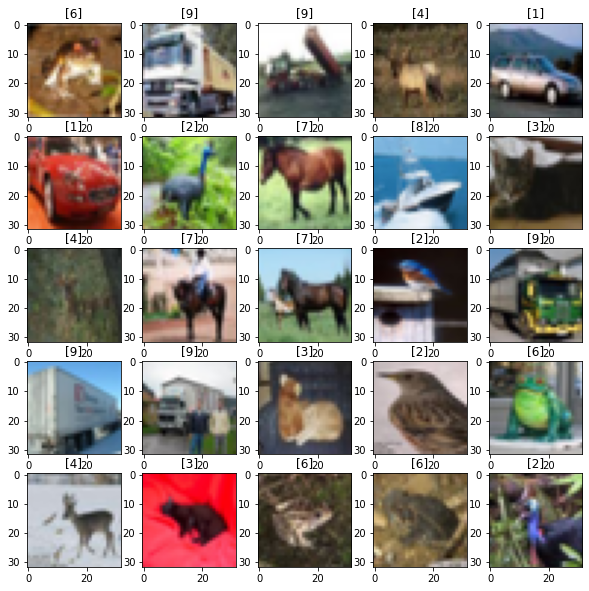

In [10]:
#5x5枚の画像を表示する
plt.figure(figsize=(10,10))
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    plt.imshow(train_images[i])
    #x軸の目盛りを消す
    plt.tick_params(labelbottom='off')
    #y軸の目盛りを消す
    plt.tick_params(labelleft='off')
    #正解ラベルを表示
    plt.title(train_labels[i])


plt.show()

クラスラベルは次の10クラス
[0] airplane (飛行機)
[1] automobile (自動車)
[2] bird (鳥)
[3] cat (猫)
[4] deer (鹿)
[5] dog (犬)
[6] frog (カエル)
[7] horse (馬)
[8] ship (船)
[9] truck (トラック)

## 前処理

ネットワークを訓練する前に、データを前処理する必要があります。最初の画像を見ると画素の値が0から255の間であることがわかります。

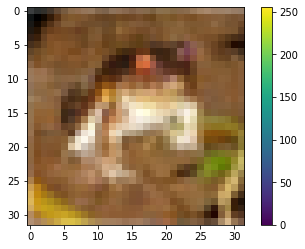

In [11]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

ニューラルネットワークにデータを投入する前に画素の値を255で割り0から1までの範囲にスケールします。

訓練用もテスト用も同じです。

In [12]:
train_images = train_images / 255.0
test_images = test_images / 255.0

訓練用データセットの最初の25枚の画像を、クラス名付きで表示します。

ネットワークを構築・訓練する前に、データが正しいフォーマットになっていることを確認します。

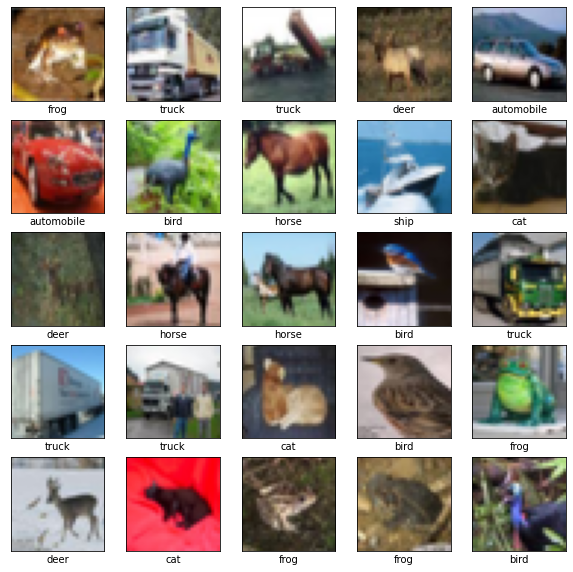

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(train_labels[i])])
plt.show()

## モデルの構築

ニューラルネットワークを構築する第一歩としてモデルの階層を定義、その後モデルをコンパイルします。

### 層の設定

ニューラルネットワークを作る上で層（layer）が基本的な構成要素。層の役割として入力されたデータから取り組もうとする問題に対し意味のある「表現」を抽出できることが求められます。

ディープラーニングのモデルは単純な層の積み重ねといっても過言ではなくtf.keras.layers.Dense のような層のほとんどに訓練中に学習されるパラメータがあります。

In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

最初の層は、tf.keras.layers.Flatten です。この層は、画像を（32×32ピクセルの）2次元配列から、1024ピクセルの、1次元配列に変換します。この層が、画像の中に積まれているピクセルの行を取り崩し、横に並べると考えてください。また、RGBに当たる3はそのままにします。ここまでの流れはデータのフォーマット変換を行うだけです。

ピクセルを１次元化しました。以後、ネットワークは2つの tf.keras.layers.Dense 層となります。これらは密結合あるいは全結合されたニューロンの層です。最初の Dense 層には、256個のノード（あるはニューロン）があります。最後の層でもある2番めの層は、10ノードのsoftmax層です。この層は、合計が1になる10個の確率の配列を返します。それぞれのノードは、今見ている画像が10個のクラスのひとつひとつに属する確率を出力します。

### モデルのコンパイル

モデルが訓練できるように設定の追加が必要です。コンパイル時に追加されます。

・損失関数（loss function） —訓練中にモデルがどれくらい正確かを測定します。損失関数を最小化することにより、訓練中のモデルを正しい方向に向かわせることとなります。

・オプティマイザ（optimizer）—モデルが見ているデータと損失関数の値をもとにモデルの更新をどう進めていくか決定します。

・メトリクス（metrics） —訓練とテストのステップを監視する際に使われます。今回はaccuracy（正解率）といい画像が正しく分類された比率を使用しています。

In [15]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               786688    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 789,258
Trainable params: 789,258
Non-trainable params: 0
_________________________________________________________________


## モデルの訓練

ニューラルネットワークの訓練ではまずモデルに訓練用データ(ここではtrain_imagesとtrain_labels)を入れて画像とラベルの対応関係を学習します。そして、モデルにテスト用データセットtest_imagesの予測(ここでは分類)を行わせて予測結果とtest_labelsで照合し正答率を確認します。

model.fit メソッドを呼び出し訓練をします。

In [16]:
model.fit(train_images, train_labels, epochs=20, batch_size=256)

Epoch 1/20
196/196 [==============================] - 5s 21ms/step - loss: 2.1896 - accuracy: 0.2562
Epoch 2/20
196/196 [==============================] - 4s 21ms/step - loss: 1.7803 - accuracy: 0.3682
Epoch 3/20
196/196 [==============================] - 4s 21ms/step - loss: 1.7133 - accuracy: 0.3948
Epoch 4/20
196/196 [==============================] - 4s 21ms/step - loss: 1.6524 - accuracy: 0.4200
Epoch 5/20
196/196 [==============================] - 4s 21ms/step - loss: 1.6102 - accuracy: 0.4329
Epoch 6/20
196/196 [==============================] - 4s 21ms/step - loss: 1.5818 - accuracy: 0.4411
Epoch 7/20
196/196 [==============================] - 4s 21ms/step - loss: 1.5466 - accuracy: 0.4564
Epoch 8/20
196/196 [==============================] - 4s 21ms/step - loss: 1.5151 - accuracy: 0.4631
Epoch 9/20
196/196 [==============================] - 4s 21ms/step - loss: 1.5142 - accuracy: 0.4722
Epoch 10/20
196/196 [==============================] - 4s 22ms/step - loss: 1.4885 - accura

## 正解率の評価

モデルの訓練ができたのでテスト用データセットに対するモデルの性能も確かめましょう。

In [17]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 1.4448 - accuracy: 0.4906

Test accuracy: 0.49059998989105225


テスト用データセットでの正解率は、訓練用データセットでの正解率よりも少し低くなりました。新しいデータに対する機械学習モデルの性能が、訓練時と比較して低下する現象過学習（over fitting）の一例です。

モデルの訓練が終わったら、そのモデルを使って画像の分類予測を行うことが出来ます。

In [18]:
predictions = model.predict(test_images)

これは、モデルがテスト用データセットの画像のひとつひとつを分類予測した結果です。最初の予測を見てみましょう。

In [19]:
predictions[0]

array([0.01279367, 0.01005951, 0.10952231, 0.2464253 , 0.11879683,
       0.19029582, 0.21369596, 0.00096528, 0.09624713, 0.00119826],
      dtype=float32)

予測結果として10個の数字の配列になっています。画像が10の項目それぞれに該当するかの「確信度」を表しています。どのラベルが一番確信度が高いかを見てみましょう。

In [20]:
np.argmax(predictions[0])

3

モデルによると最初の画像は[3] cat (猫)である可能性が最も高いと判断したことになります。これが正しいかどうか、テスト用ラベルを見てみましょう。

In [21]:
test_labels[0]

array([3], dtype=uint8)

見事正解です。

10チャンネルすべてをグラフ化すると以下のように。

In [22]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label[0]]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label[0]].set_color('blue')

先程の画像で試してみましょう。

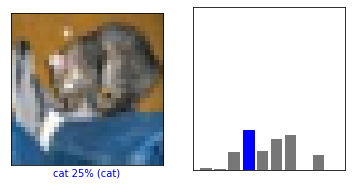

In [23]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

予測の中のいくつかの画像を、予測値とともに表示してみましょう。予測が合っている場合は青で、誤っている場合は赤で表示されます。数字は予測したラベルのパーセント（100分率）を示します。

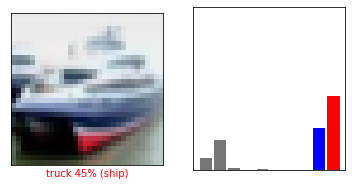

In [24]:
i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

他の画像も予測してみて予測値とともに表示してみましょう。正しい予測は青で、誤っている予測は赤でラベルを表示します。数字は予測したラベルのパーセント（100分率）を示します。

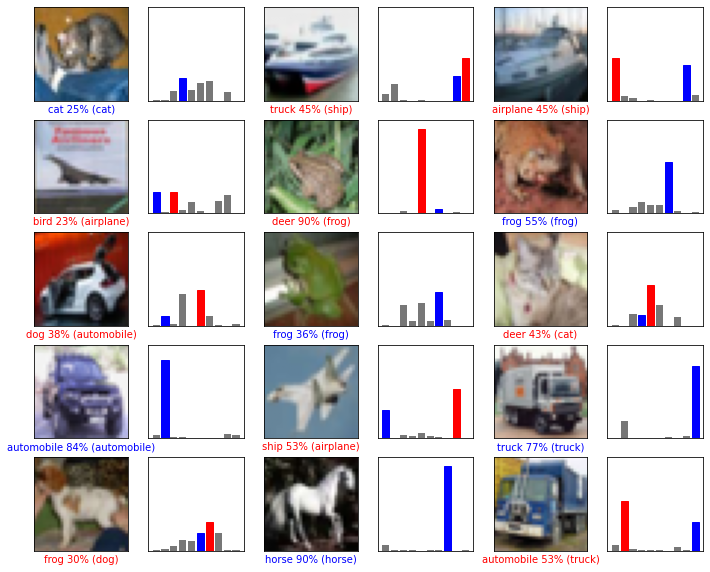

In [25]:
# X個のテスト画像、予測されたラベル、正解ラベルを表示します。
# 正しい予測は青で、間違った予測は赤で表示しています。
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
plt.show()

こうやって見てみるとモデル側が自信を持って予測していても間違いは起こりうるということがわかります。